In [4]:
# class to form the basis feature
import numpy as np
import scipy as sc

class xdes:
    
    def __init__(self,X):
        self.x=X
    
    
    def iden(self):
        return self.x
    
    def mon(self,N):
        x_mon=np.ones(self.x.shape[0])[:,None]
        for s in range(1,N+1):
            x_mon=np.hstack((x_mon,self.x**s))
        
        return x_mon
    
    def four(self,N):
        xfour=np.hstack((np.zeros(self.x.shape[0])[:,None],np.ones(self.x.shape[0])[:,None]))
        for s in range(1,N+1):
            xfour=np.hstack((xfour,np.hstack((np.sin(s*np.pi*self.x),np.cos(s*np.pi*self.x)))))
        
        return xfour
    
    def lege(self,N):
        w=sc.special.legendre(1)
        lege_2=w(self.x)
        lege_1=lege_2
        for s in range (2,N+1):
            w=sc.special.legendre(s)
            lege_2=w(self.x)
            lege_1=np.hstack((lege_1,lege_2))
        return lege_1
    

In [9]:
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from pyDOE import lhs
import matplotlib.pyplot as plt
import sklearn.metrics as sk
from random import choices
from numpy import genfromtxt

my_data = genfromtxt('data.csv', delimiter=',')[1:,0:-1]        #extract all elements except the first row and the last column
training = my_data[0:6666,:]                                    # using the first 2/3 of the data for training
testing = my_data[6667:,:]
#x_1=my_data[0:6666,:-1]
#y=my_data[0:6666,-1]

a=0.02
b_1=0.9
b_2=0.999
e=10**-7
Nt=20000                      # number of iterations
batch=32                      # batch size
los_1=[]

def generate_rand():
    weight = np.random.random_sample([13,1])
    return weight

def neglog(w_1):      
    wTx = np.dot(x_1,w_1)
    ai =  1/(1+np.exp(wTx))
    loss = -np.matmul(y.T,np.log(ai)) - np.matmul((1-y).T,np.log(1-ai))
    return loss

def batch_size():
    indices=choices(range(0,training.shape[0]),k=batch)
    randomset=training[indices]
    y=randomset[:,-1][:,None]
    x_1=np.hstack((randomset[:,:-1],np.ones([batch,1])))
    return x_1, y
#geenrate initial random weights
w_1 = generate_rand()
m_w_1=np.zeros((13,1))
v_w_1=np.zeros((13,1))


jacobian_w = jacobian(neglog,0)



for t in range(1,Nt):
            #iteration number
       #Extract batch size of elements randomly from the main training dataset
       x_1,y=batch_size()

        #convert the y in the training dataset to 0,1
       y=(np.sign(y)*2+2)/4
       #Adam optimiser
       m_w_1 = b_1*m_w_1 + (1-b_1)*np.reshape(jacobian_w(w_1),(13,1))
       v_w_1 = b_2*v_w_1 + (1-b_2)*np.power(np.reshape(jacobian_w(w_1),(13,1)),2)
      
       m_w_t=m_w_1/(1-np.power(b_1,t))
       v_w_t=v_w_1/(1-np.power(b_2,t))
       
       w_1 = w_1 - a*np.divide(m_w_t,np.sqrt(v_w_t)+e)
       wTx = np.matmul(x_1,w_1)
       ai =  1/(1+np.exp(wTx))
       los = -np.matmul(y.T,np.log(ai)) - np.matmul((1-y).T,np.log(1-ai))
       los_1 = np.append(los_1,los)

#training dataset evaluation
x_train=x_test=np.hstack((training[:,:-1],np.ones([6666,1])))
y_train=((np.sign(training[:,-1])+1)/2)[:,None]
y_train_p = (np.sign(1/(1+np.exp(np.dot(x_train,w_1)))-0.5)+1)/2
zt = sk.confusion_matrix(y_train,y_train_p)

#testing dataset evaluation
x_test=np.hstack((testing[:,:-1],np.ones([3333,1])))
y_test=((np.sign(testing[:,-1])+1)/2)[:,None]
y_test_p = (np.sign(1/(1+np.exp(np.dot(x_test,w_1)))-0.5)+1)/2
z = sk.confusion_matrix(y_test,y_test_p)
den=np.sum(z)
num=np.trace(z)
accuracy=num/den


In [10]:
#print(zt)
print("confusion matrix =",z)   #confusion matrix on testing data
print("accuracy = ",accuracy*100,"%")  #accuracy on this confusion matrix

confusion matrix = [[ 851  372]
 [ 296 1814]]
accuracy =  79.95799579957996 %


Text(0, 0.5, '$Loss$')

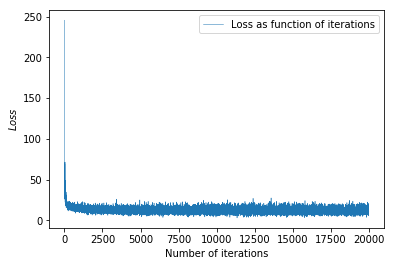

In [11]:

plt.plot(los_1,linewidth=0.5,label='Loss as function of iterations')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('$Loss$')